In [4]:
%%capture
pip install pennylane

In [5]:
import pennylane as qml
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
import matplotlib.pyplot as plt

## Electron-Photon dataset

In [8]:
!unzip datasets_hd5.zip

Archive:  datasets_hd5.zip
  inflating: Electron-Photon-bilinear-tracker-(16, 16, 1).h5  
  inflating: QG-bilinear-tracker-(16, 16, 1).h5  


In [9]:
import h5py
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torchvision import transforms

path_ep = "/content/Electron-Photon-bilinear-tracker-(16, 16, 1).h5"
with h5py.File(path_ep, "r") as file:
    X_ep = np.array(file["X"])
    y_ep = np.array(file["y"])

X_train_16, X_test_16, Y_train_16, Y_test_16 = train_test_split(X_ep, y_ep, test_size=0.2, random_state=42, stratify=y_ep)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((16, 16)),
    transforms.ToTensor()
])

X_train_resized = torch.stack([transform(x) for x in X_train_16])
X_test_resized = torch.stack([transform(x) for x in X_test_16])

X_train = X_train_resized.permute(0, 2, 3, 1)
X_test = X_test_resized.permute(0, 2, 3, 1)

y_train = torch.tensor(Y_train_16)
y_test = torch.tensor(Y_test_16)

print(X_train.shape)
print(X_test.shape)

torch.Size([160000, 16, 16, 1])
torch.Size([40000, 16, 16, 1])


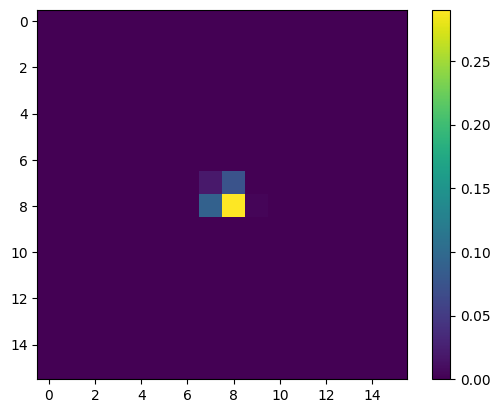

tensor(1, dtype=torch.int32)


In [10]:
n = 5
plt.imshow(X_train[n])
plt.colorbar()
plt.show()
print(y_train[n])

## model: FC + QC + FC + SOFTMAX


In [11]:
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

In [12]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

clayer_1 = torch.nn.Linear(256, 256)
clayer_2 = torch.nn.Linear(8, 2)
softmax = torch.nn.Softmax(dim=1)

layers = [clayer_1, qlayer, clayer_2, softmax]
model = torch.nn.Sequential(*layers)

opt = torch.optim.SGD(model.parameters(), lr=0.1)
loss = torch.nn.L1Loss()

In [13]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

print(model[1].parameters())

Total trainable parameters: 65858
<generator object Module.parameters at 0x792585fa9fc0>


In [14]:
import torch
import torch.nn.functional as F
import torch.utils.data
import numpy as np
import csv
import time

# Assuming model, opt, loss, X_train, y_train are already defined

# one-hot encoding
num_classes = 2
samples = 10000
y_train_one_hot = F.one_hot(
    y_train[:samples].to(torch.int64), num_classes=num_classes
)

X = X_train[:samples].reshape(samples, 16 * 16).float().requires_grad_(True)
y_hot = y_train_one_hot.long()

batch_size = 64
batches = samples // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_hot)), batch_size=batch_size, shuffle=True, drop_last=True
)

epochs = 50
subset_size = samples  # 10% of full dataset, assuming full dataset is 100,000

start_time = time.time()

for epoch in range(epochs):
    running_loss = 0
    for xs, ys in data_loader:
        opt.zero_grad()
        y_pred = model(xs)
        loss_evaluated = loss(y_pred, ys)
        loss_evaluated.backward()
        opt.step()
        running_loss += loss_evaluated.item()
    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

training_time = time.time() - start_time

# Calculate final train accuracy
start_time = time.time()
y_pred = model(X)
inference_time = time.time() - start_time

_, y_pred_classes = torch.max(y_pred, dim=1)
y_pred_classes = y_pred_classes.detach().numpy()

correct = (y_pred_classes == y_train[:samples].numpy()).sum()
final_train_accuracy = correct / len(y_train[:samples])
print(f"Final Train Accuracy: {final_train_accuracy * 100:.2f}%")

# Assuming you have a separate test set, you would calculate test accuracy here
# For this example, we'll use the same data as a placeholder
final_test_accuracy = final_train_accuracy

# Prepare metrics for CSV
metrics = {
    'Optimizer': type(opt).__name__,
    'Learning_Rate': opt.param_groups[0]['lr'],
    'Weight_Decay': opt.param_groups[0]['weight_decay'] if 'weight_decay' in opt.param_groups[0] else 'N/A',
    'Batch_Size': batch_size,
    'Epochs': epochs,
    'Loss_Function': type(loss).__name__,
    'Training_Subset_Size': f"{subset_size} (10% of full dataset)",
    'Training_Time': f"{training_time:.2f}",
    'Inference_Time': f"{inference_time:.2f}",
    'Final_Train_Accuracy': f"{final_train_accuracy:.2f}",
    'Final_Test_Accuracy': f"{final_test_accuracy:.2f}"
}

# Write metrics to CSV
csv_filename = 'hybrid_EQCNN_fashion_mnist_metrics.csv'
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=metrics.keys())
    writer.writeheader()
    writer.writerow(metrics)

print(f"Metrics have been saved to {csv_filename}")

Average loss over epoch 1: 0.4990
Average loss over epoch 2: 0.4957
Average loss over epoch 3: 0.4761
Average loss over epoch 4: 0.4552
Average loss over epoch 5: 0.4417
Average loss over epoch 6: 0.4406
Average loss over epoch 7: 0.4308
Average loss over epoch 8: 0.4271
Average loss over epoch 9: 0.4266
Average loss over epoch 10: 0.4241
Average loss over epoch 11: 0.4320
Average loss over epoch 12: 0.4204
Average loss over epoch 13: 0.4189
Average loss over epoch 14: 0.4138
Average loss over epoch 15: 0.4173
Average loss over epoch 16: 0.4192
Average loss over epoch 17: 0.4190
Average loss over epoch 18: 0.4164
Average loss over epoch 19: 0.4123
Average loss over epoch 20: 0.4157
Average loss over epoch 21: 0.4152
Average loss over epoch 22: 0.4102
Average loss over epoch 23: 0.4133
Average loss over epoch 24: 0.4105
Average loss over epoch 25: 0.4138
Average loss over epoch 26: 0.4135
Average loss over epoch 27: 0.4113
Average loss over epoch 28: 0.4108
Average loss over epoch 29: 0

In [15]:
samples = 5000
X = X_train[:samples].reshape(samples, 16*16).float().requires_grad_(True)

y_pred = model(X)

_, y_pred_classes = torch.max(y_pred, dim=1)
y_pred_classes = y_pred_classes.detach().numpy()

correct = (y_pred_classes == y_train[:samples].numpy()).sum()
accuracy = correct / len(y_train[:samples])
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 61.46%


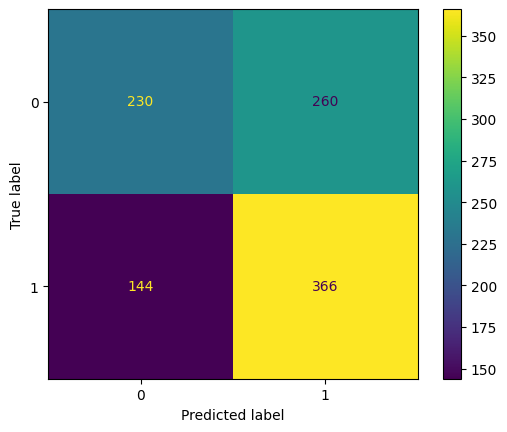

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_samples = 1000
X_test = X_test[:test_samples].reshape(test_samples, 16*16).float().requires_grad_(True)

y_pred = model(X_test)
_, y_pred_classes = torch.max(y_pred, dim=1)
y_pred_classes = y_pred_classes.detach().numpy()

cm = confusion_matrix(y_test[:test_samples], y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()